# Training my First RNN

In [104]:
import pandas as pd
import numpy as np

In [106]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

In [115]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### Importing Data

In [ ]:
data = pd.read_csv("../../../data/time_series/clean_weather.csv")
data = data.ffill()
# Display a sequence of temperatures
data["tmax"].head(10)

0    60.0
1    52.0
2    52.0
3    53.0
4    52.0
5    50.0
6    52.0
7    56.0
8    54.0
9    57.0
Name: tmax, dtype: float64

##### Create sequences from a time seriees by movind windoow:

In [107]:
targets_numpy = data.tmax_tomorrow.values
features_numpy = data[["tmax", "tmin", "rain" ]].values


In [108]:
features_numpy_seq  = []
targets_numpy_seq  = []

seq_dim = 20

for i, first_point in enumerate(targets_numpy):
    if i+seq_dim<=targets_numpy.shape[0]:
        targets_numpy_seq.append(targets_numpy[i:i+seq_dim])
        features_numpy_seq.append(features_numpy[i:i+seq_dim])

    else:
        targets_numpy_seq.append(targets_numpy[i:targets_numpy.shape[0]])
        features_numpy_seq.append(features_numpy[i:features_numpy.shape[0]])
        break;
        
# features_numpy_seq = np.asarray(features_numpy_seq)
# targets_numpy_seq = np.asarray(targets_numpy_seq)


In [109]:
train_set_split = 0.2
train_set_split_len = int(len(targets_numpy_seq)*train_set_split)

features_train = features_numpy_seq[0:train_set_split_len]
features_test = features_numpy_seq[train_set_split_len:]

targets_train = targets_numpy_seq[0:train_set_split_len]
targets_test = targets_numpy_seq[train_set_split_len:]



In [110]:
#  create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.tensor(features_train)
targetsTrain = torch.tensor(targets_train)

In [111]:
# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)

In [113]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [114]:
# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)

In [137]:
from torch.nn.functional import tanh

class RNN_model(nn.Module):
    def __init__(self,input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = -torch.ones(self.layer_dim, x.size(0), self.hidden_dim)/(20*self.hidden_dim)
        # print(x.size())
        # One time step
        r_out, hn = self.rnn(x, h0)

        r_out = r_out.reshape(-1, self.hidden_dim)
        # return r_out
        out = self.fc(r_out)
        out = out.reshape(-1, self.output_dim , 1)
        # print(out.size())
        return out
        

In [138]:
# Create RNN
input_dim = 3    # input dimension
hidden_dim = 50  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 1   # output dimension

model = RNN_model(input_dim, hidden_dim, layer_dim, output_dim)

In [139]:
# Cross Entropy Loss 
error = nn.L1Loss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [140]:
epochs_loss = []

In [141]:

for epoch in range(10000):

    for i, (X, y) in enumerate(train_loader):

        # train  = Variable(X.view(-1, seq_dim, input_dim))
        labels = Variable(y )

        # Clear gradients
        optimizer.zero_grad()
        
        X = torch.reshape(X, (X.size()[0], seq_dim, input_dim ))
        # X = torch.reshape(X, (batch_size, 1, input_dim ))
        X = torch.tensor(X, dtype=torch.float)


        # print(y.size())
        y = torch.reshape(y, (-1, 1, 1))
        y = torch.tensor(y, dtype=torch.float)

        if torch.isnan(X).any().numpy():
            print("NAN")
        # Forward propagation
        outputs = model(X)

        # Calculate softmax and ross entropy loss
        loss = error(outputs, y)

        # Calculating gradients
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 0.9)
        # Update parameters
        optimizer.step()

        epochs_loss.append(loss.item())


        

/var/folders/f9/kmz_nck52zn4vfbt9qh0px5r0000gn/T/ipykernel_3617/1128794230.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
/var/folders/f9/kmz_nck52zn4vfbt9qh0px5r0000gn/T/ipykernel_3617/1128794230.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float)


In [142]:
epochs_loss_edit = [10 if x>10 else x  for x in epochs_loss]

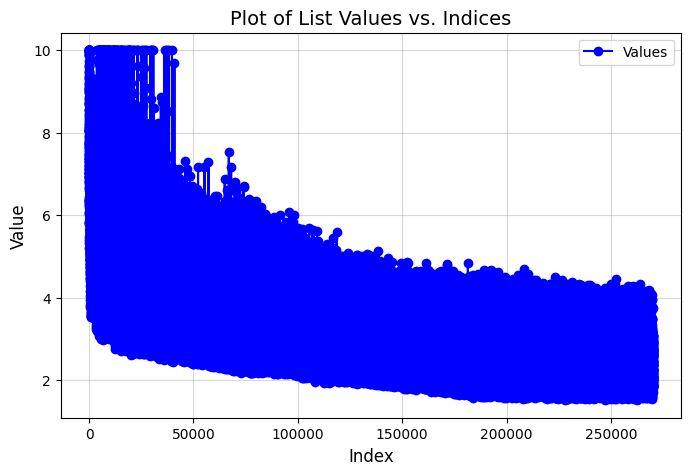

In [145]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(range(len(epochs_loss_edit)), epochs_loss_edit, marker='o', linestyle='-', color='b', label='Values')

# Adding labels and title
plt.title('Plot of List Values vs. Indices', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(alpha=0.5)
plt.legend()


# Show plot
plt.show()

### calculating MSE for test data

In [133]:
all_loss = []
all_loss_ = []

for i, one_batch in enumerate(features_test):
    X = torch.from_numpy(one_batch)
    X = torch.reshape(X, (1, -1, input_dim ))
    # X = torch.reshape(X, (batch_size, 1, input_dim ))
    X = torch.tensor(X, dtype=torch.float)
    pred = model(X)

    y = targets_test[i]
    y = torch.from_numpy(y)
    y = torch.reshape(y, (y.size()[0], 1, 1 ))
    loss = error(pred, y)
    
    y = y.flatten().detach().numpy()
    pred = pred.flatten().detach().numpy()

    loss_ = np.sum(abs(pred- y))/len(pred)
    

    all_loss.append(loss.item())
    all_loss_.append(loss_)

    

/var/folders/f9/kmz_nck52zn4vfbt9qh0px5r0000gn/T/ipykernel_3617/3706676306.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


In [134]:
np.sum(all_loss_)/len(all_loss_)

np.float64(4.65579261008352)

Looks like there is a 4.5 average error of temperature in the forecasting. Which seems large variance. next step. 
 - Train a LR
 - Train an LSTM

Matplotlib is building the font cache; this may take a moment.
/var/folders/f9/kmz_nck52zn4vfbt9qh0px5r0000gn/T/ipykernel_50471/2538420599.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=100, freq='H'),


Epoch [10/50], Loss: 0.1188
Epoch [20/50], Loss: 0.0946
Epoch [30/50], Loss: 0.0947
Epoch [40/50], Loss: 0.0941
Epoch [50/50], Loss: 0.0933
Root Mean Squared Error (RMSE): 217.75504036183378
Mean Absolute Error (MAE): 183.81
Mean Absolute Percentage Error (MAPE): 48.34%


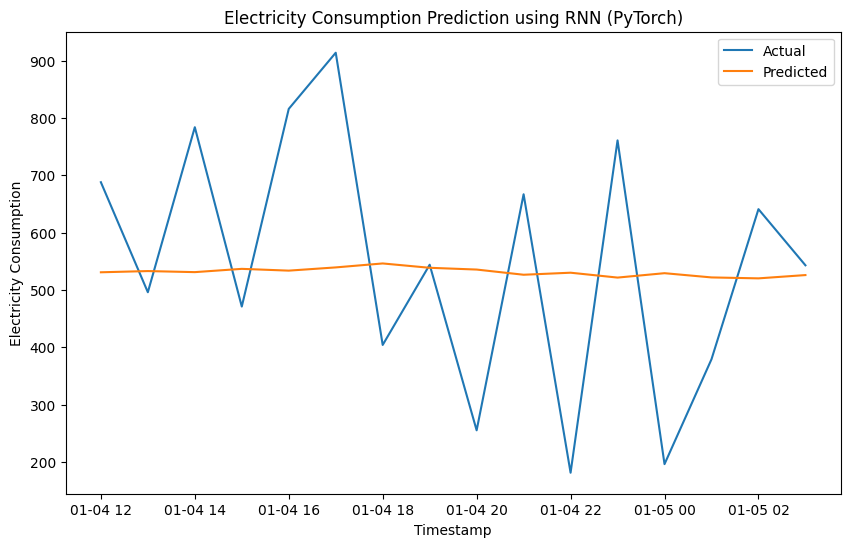

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Sample data for Electricity Consumption 
data = {
    'timestamp': pd.date_range(start='2023-01-01', periods=100, freq='H'),
    'consumption': np.random.randint(100, 1000, 100)
}
df = pd.DataFrame(data)
df.set_index('timestamp', inplace=True)

# Preprocessing
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create sequences and labels for training
seq_length = 24
X, y = [], []
for i in range(len(df_scaled) - seq_length):
    X.append(df_scaled[i:i + seq_length])
    y.append(df_scaled[i + seq_length])


X, y = np.array(X), np.array(y)

# Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create a custom dataset class for PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 128
output_size = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = model(X_test_tensor).numpy()
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# Visualize predictions against actual data
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+seq_length:], y_test, label='Actual')
plt.plot(df.index[train_size+seq_length:], y_pred, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Prediction using RNN (PyTorch)')
plt.legend()
plt.show()

In [144]:
for inputs, targets in train_loader:
    print(len(inputs[0]))

24
